Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
#test_label = test[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

In [5]:
test_img.shape

(28000, 28, 28)

## Визуализируем исходные данные

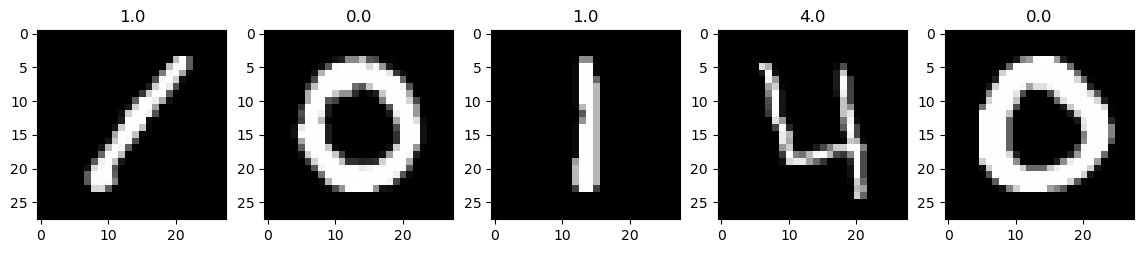

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

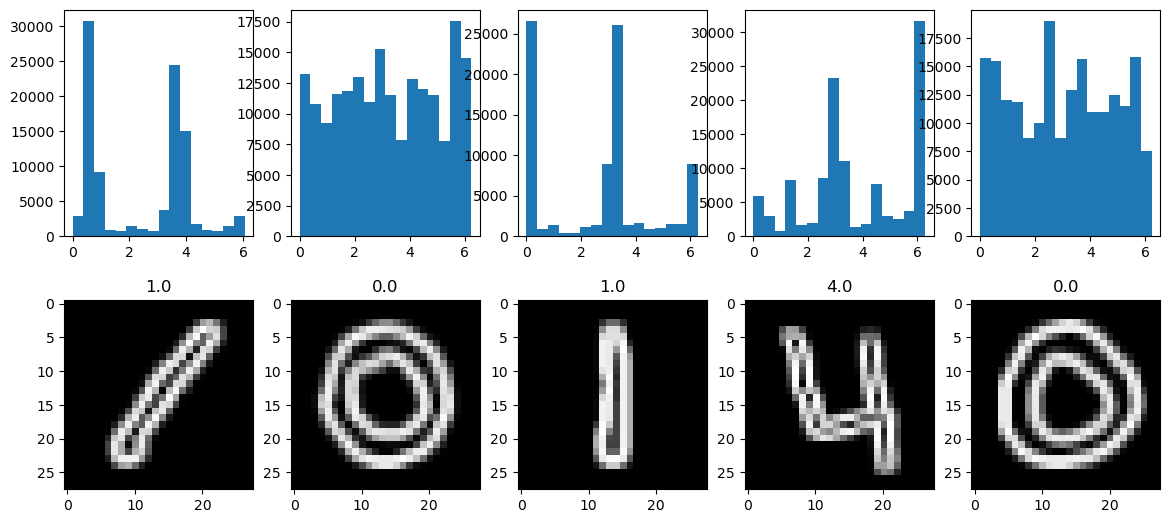

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [13]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [14]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [15]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [16]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Используем kNN

Этот метод работает с помощью поиска кратчайшей дистанции между тестируемым объектом и ближайшими к нему классифицированным объектами из обучающего набора. Классифицируемый объект будет относится к тому классу, к которому принадлежит ближайший объект набора.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [18]:
a = 0 #обычный kNN, но устроила перебор соседей циклом
for i in range(1,150,10):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    acc = accuracy_score(y_val, predictions)
    if a < acc:
        a = acc
        n_neigh = i
print('Accuracy:', a,'\nКоличество соседей:', n_neigh)

Accuracy: 0.6189285714285714 
Количество соседей: 21


## Метод опорных векторов

Работа метода опорных векторов заключается в рисовании линии между разными кластерами точек, которые нужно сгруппировать в классы. С одной стороны линии будут точки, принадлежащие одному классу, с другой стороны — к другому классу.

Классификатор будет пытаться увеличить расстояние между рисуемыми линиями и точками на разных сторонах, чтобы увеличить свою «уверенность» определения класса.

In [19]:
from sklearn import svm

In [47]:
model = svm.SVC()

In [48]:
model.fit(x_train, y_train)

SVC()

In [49]:
predictions = model.predict(x_val)
acc = accuracy_score(y_val, predictions)
acc

0.6529761904761905

In [50]:
predictions.shape

(8400,)

In [51]:
predictions = model.predict(test_hist)
#acc = accuracy_score(test_label, predictions)
#acc

In [52]:
predictions

array([2., 5., 9., ..., 3., 9., 3.])

## Гауссовский наивный байес

Применение теоремы Байеса с «наивным» предположением об условной независимости между каждой парой характеристик при заданном значении переменной класса.

GaussianNB реализует гауссовский наивный байесовский алгоритм для классификации. Предполагается, что вероятность появления признаков гауссова.

In [26]:
from sklearn.naive_bayes import GaussianNB

In [27]:
model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

In [28]:
predictions = model.predict(x_val)
acc = accuracy_score(y_val, predictions)
acc

0.528452380952381

## Линейный дискриминантный анализ

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [30]:
model = LinearDiscriminantAnalysis()
model.fit(x_train, y_train)

LinearDiscriminantAnalysis()

In [31]:
predictions = model.predict(x_val)
acc = accuracy_score(y_val, predictions)
acc

0.5572619047619047

## Готовим файл для отправки

Отправляю результаты метода опорных векторов как самого лучшего.

In [53]:
predictions = predictions.astype(int)

In [54]:
len(predictions)

28000

In [55]:
predictions

array([2, 5, 9, ..., 3, 9, 3])

In [56]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predictions, 1):
        dst.write('%s,%s\n' % (i, p))

### Вывод:

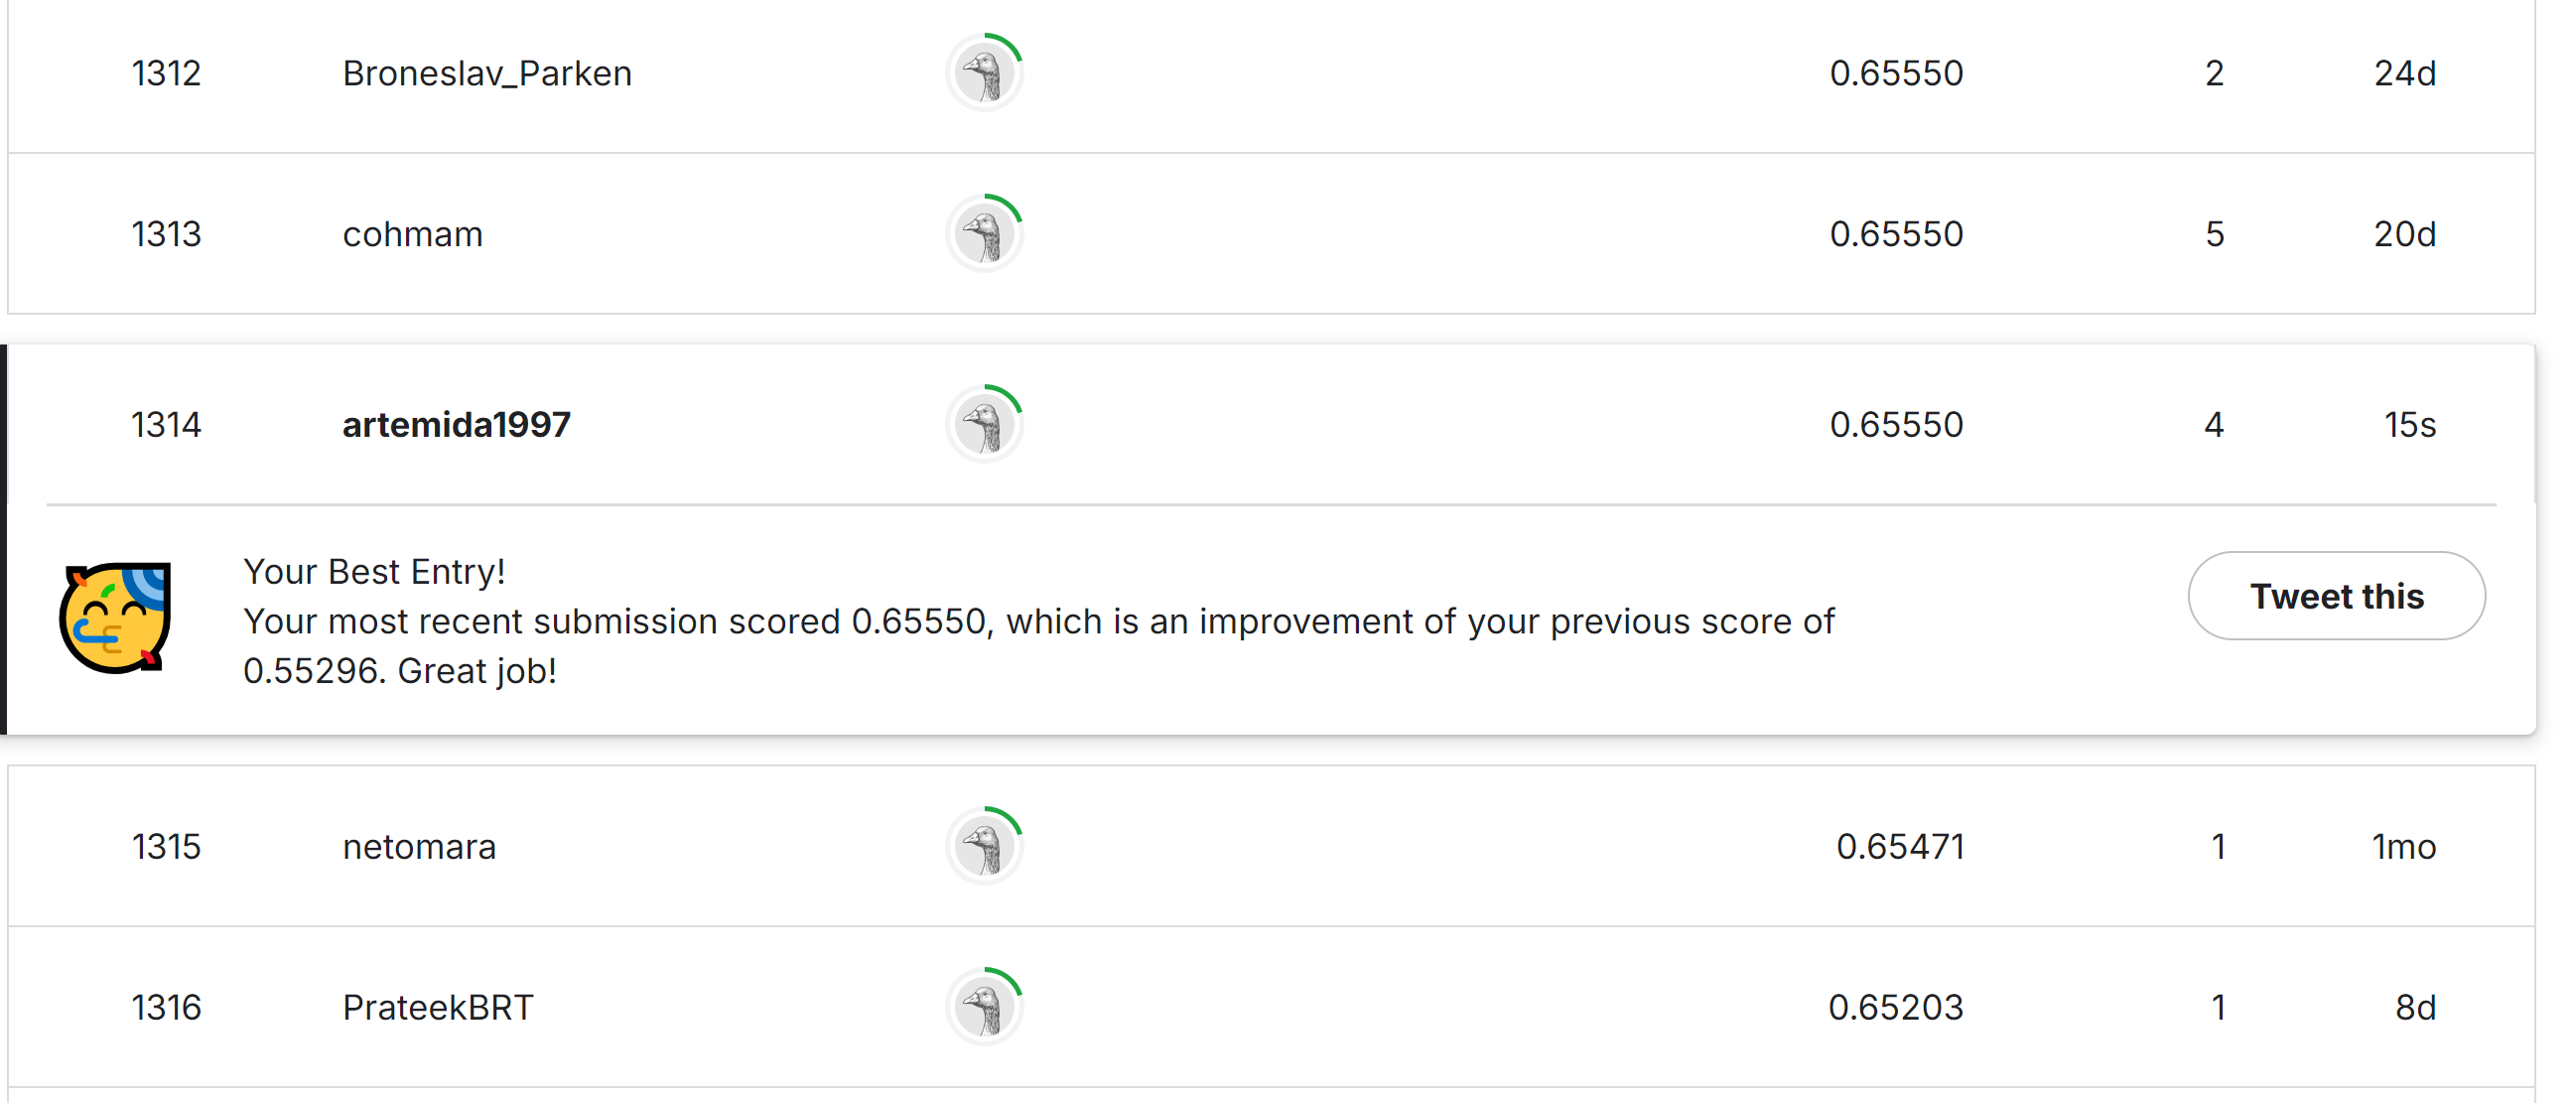

In [59]:
from IPython.display import Image
Image("kaggle.png")



<font size=4 color='green'>Модель</font>|<font size=4 color='green'>Результат</font>
-|-
<font size=3 color='blue'> kNN </font>|<font size=3, color='blue'> 0.619 <font>
<font size=3 color='blue'> SVM </font>|<font size=3, color='blue'> 0.653 <font>
<font size=3 color='blue'> GaussianNB </font>|<font size=3, color='blue'> 0.528 <font>
<font size=3 color='blue'> LDA </font>|<font size=3, color='blue'> 0.557 <font>